In [1]:
# !pip install xlrd
!pip install openpyxl
!pip install pmdarima

     |████████████████████████████████| 242 kB 4.5 MB/s 
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8913 sha256=698b53bf3c51197a465856cd335bed33fb5cee876a0c2b0a323ab65f0e8aad92
  Stored in directory: /root/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 1.5 MB 4.4 MB/s 
     |████████████████████████████████| 2.1 MB 27.6 MB/s 
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


Hello guys, here we are going to look into a business requirement, where product demand forecasting is required. Problem is that, we have 'n' number of products, out of which, oldest product demand history contains 3 years of monthly numbers, and newly launched product contains as less as 1 month observation. 

Now, we are required to give a forecast for next 12 months, technique and methodology is completely up to us. We basically need to make sure that our modelling technique selects the products dynamically, means that, we may want to deploy multiple modelling strategies to make sure that we are getting a benefit of multivariate forecasting, wherever possible.

In [2]:
# Library Import
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno
from datetime import date
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import aic
from pmdarima import auto_arima

import seaborn as sns # for plot visualization
scaler = MinMaxScaler()
pd.options.mode.chained_assignment = None

### Read product demand history:

In [3]:
df = pd.read_excel('../input/forecasting-usecase-task/history_and_forecast_data.xlsx')

In [4]:
ts = df.set_index('Time series ID')
ts.index.name = 'Date'
ts.columns = ts.columns.astype(str)

In [5]:
train_set, test_set = ts.loc[:"2018-12-01",], ts.loc["2019-01-01":,]

### Analysing demand unavailability for products:

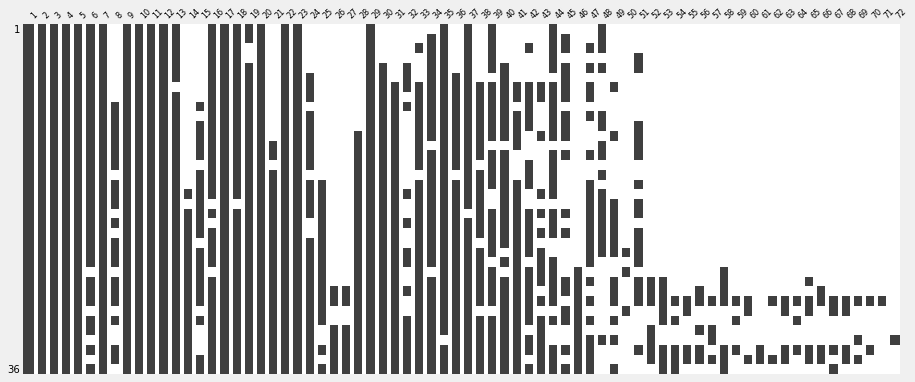

In [6]:
missingno.matrix(train_set.replace(0, np.nan), figsize=(14, 6), labels=True, sparkline=False, fontsize=8);

In [7]:
train_set.replace(0, np.nan).isna().sum().to_csv('products_unavailability_count.csv')
# test_set.replace(0, np.nan).isna().sum().plot(kind='bar', figsize=(14,7));

### Product group formation (based on data availability):

In [8]:
# Selecting products with max six months of missing information.
group1_products = pd.DataFrame()
group2_products = pd.DataFrame()
group3_products = pd.DataFrame()

for col in train_set.columns.unique():
    prod_df = train_set[col].reset_index().copy()
    prod_df.rename(columns={
        f'{col}': 'qty' 
    }, inplace=True)
    prod_df['product_id'] = col
    # At least 2 years of available record    
    if len(train_set[train_set[col]!=0]) >= 24:
        group1_products = pd.concat([group1_products, prod_df], axis=0)

    # 1-2 years of available record
    elif len(train_set[train_set[col]!=0]) in range(12, 24):
        group2_products = pd.concat([group2_products, prod_df], axis=0)
    
    # if <1 year of record is available
    else:
        group3_products = pd.concat([group3_products, prod_df], axis=0)
        

In [9]:
print(f'Group 1 products: {group1_products.product_id.unique()}')
print(f'Group 2 products: {group2_products.product_id.unique()}')
print(f'Group 3 products: {group3_products.product_id.unique()}')

Group 1 products: ['1' '2' '3' '4' '5' '6' '7' '9' '10' '11' '12' '13' '16' '17' '18' '19'
 '20' '22' '23' '24' '28' '29' '30' '31' '33' '34' '35' '36' '37' '38'
 '39' '40' '41' '44']
Group 2 products: ['8' '14' '15' '21' '25' '32' '42' '43' '45' '47' '48' '49' '51']
Group 3 products: ['26' '27' '46' '50' '52' '53' '54' '55' '56' '57' '58' '59' '60' '61'
 '62' '63' '64' '65' '66' '67' '68' '69' '70' '71' '72']


### Group 1 - Multivariate product demand data preparation:

In [10]:
train_set[group1_products.product_id.unique()].corr().to_csv('./group1_correlation.csv')

## Multivariate Modelling

These product subsets are identified based on prodct correlation report we generated earlier.

Grangers Causality would make a more sense if we had more data points.

In [11]:
###
# {
#   subset-i: productids
# }
###

multivariate_model_subset_dict = {
    1: ['1', '4', '9'],
    2: ['2', '3', '5', '7'],
    3: ['16', '17'],
    4: ['35', '37', '39', '40'],
    5: ['22', '36']
}

multivariate_product_set = set([prod for prod_set in multivariate_model_subset_dict.values() for prod in prod_set ])

### Visualize all Group 1, product subsets for Multivariate modelling

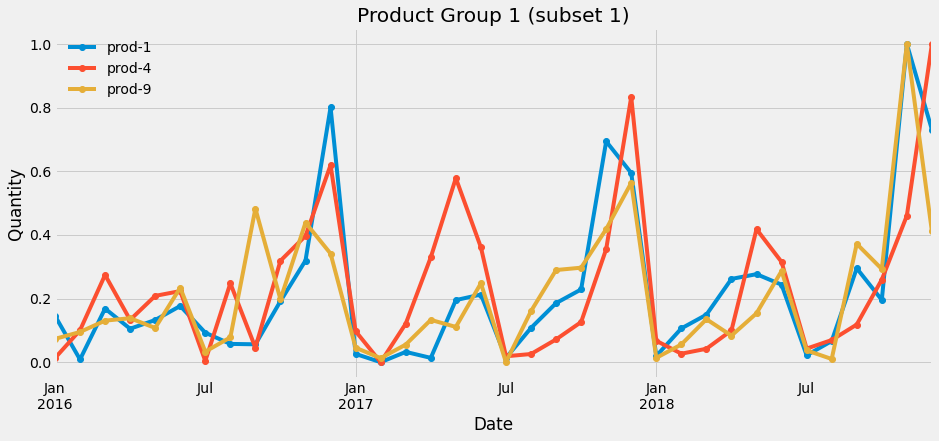

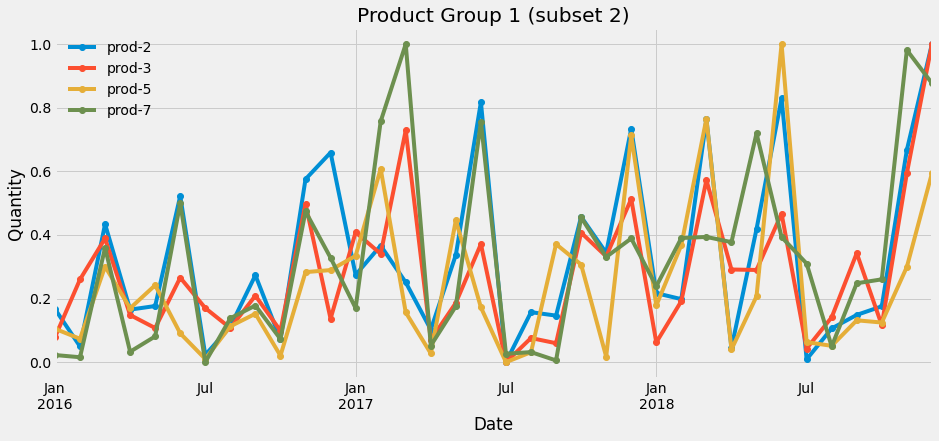

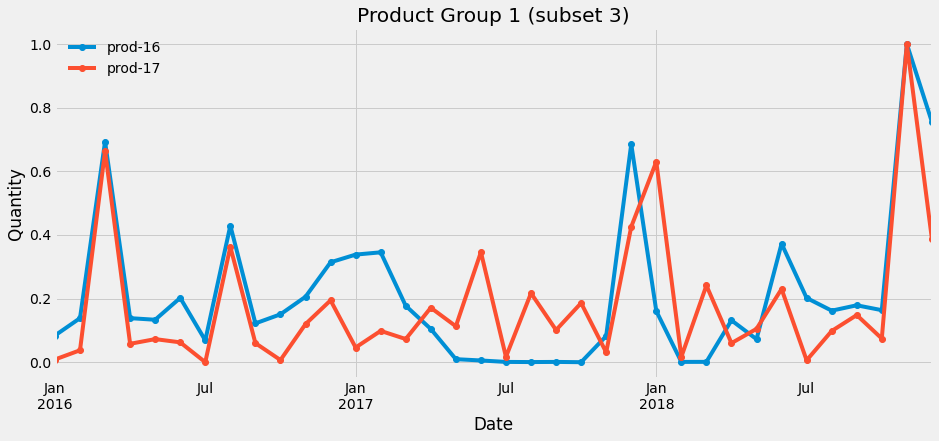

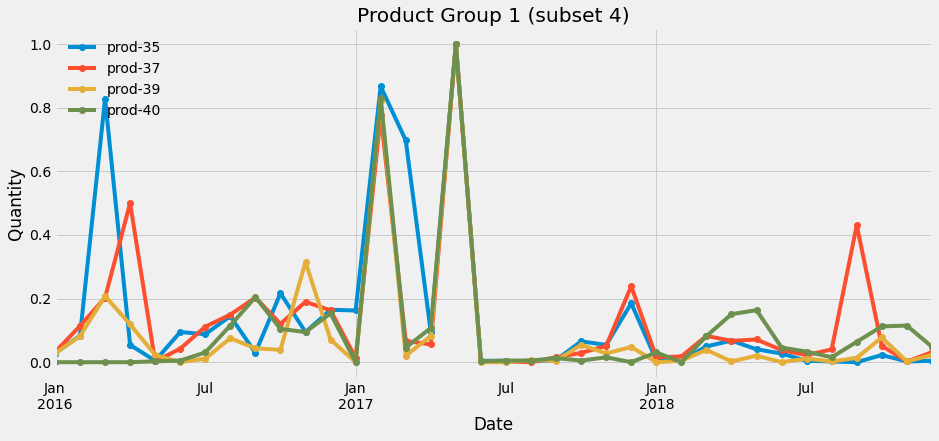

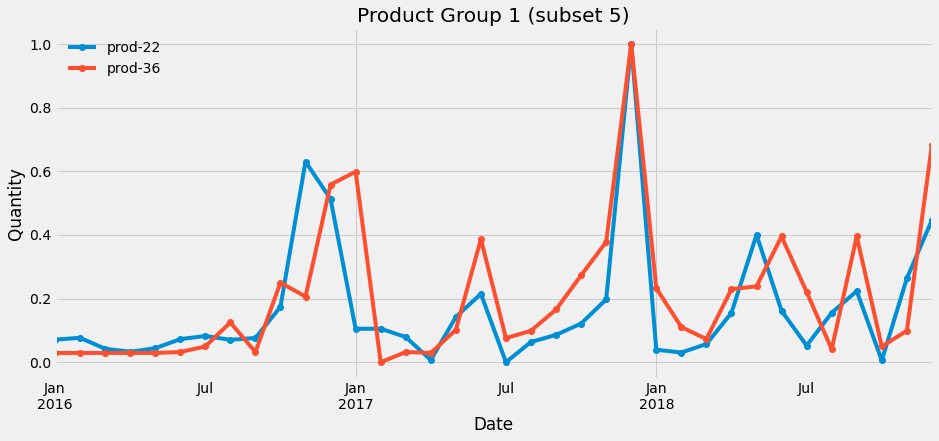

In [12]:
for key, prod_ids in multivariate_model_subset_dict.items():
    for prod_id in prod_ids:
        product = group1_products[group1_products.product_id==prod_id]
        product.loc[:,'qty'] = scaler.fit_transform(product['qty'].values.reshape(-1, 1))
        ax = product.set_index('Date').qty.plot(figsize=(14,6), marker='o', label=f'prod-{prod_id}');
        ax.legend(loc='upper left', frameon=False)

    plt.title(f'Product Group 1 (subset {key})')
    plt.ylabel('Quantity')
    plt.show()

In [13]:
# Imputation Technique
# Give a try to MICE

def impute_missing_values(prods_df):
    prods_df[prods_df <= 0] = np.nan
    prods_df.interpolate(method='spline', order=2, limit_direction='both', axis=0, inplace=True)

    return prods_df

In [14]:
# Perform ADF Test
def adfuller_test(series, signif=0.05, verbose=False):
    """
    This function performs ADF test on input
    series to and checks for stationarity
    Parameters:
    series: train set timeseries (all indices)
    signif: significance level
    verbose: Flag to handle print statemetns
    Returns:
    is_stationary: Flag, to show if TS is stationary or not
    """
    is_stationary = False
    r = adfuller(series, autolag='AIC')
    output = dict([('test_statistic', round(r[0], 4)),
                   ('pvalue', round(r[1], 4)),
                   ('n_lags', round(r[2], 4)), ('n_obs', r[3])])
    p_value = output['pvalue']
    if p_value <= signif:
        is_stationary = True
        if verbose:
            print(f" --> P-Value = {p_value}. Rejecting Null Hypothesis.")
            print(f" --> Series is Stationary.")
    else:
        if verbose:
            print(f""" --> P-Value =
            {p_value}. Weak evidence to reject the Null Hypothesis.""")
            print(f" --> Series is Non-Stationary.")
    return is_stationary

In [15]:
def invert_transformation(df_train, df_forecast, used_diff_order):
    """
    Function performs invert transformation
    Parameters:
    df_train: train set,
    df_forecast: forecast values,
    used_diff_order: used differencing order to make series stationary
    Returns:
    df_fc: inverted forecasted series
    """
    df_fc = df_forecast.copy()
    columns = df_train.columns

    for col in columns:
        # Roll back 2nd Diff
        if used_diff_order == 2:
            df_fc[str(col) + '_1'] = (df_train[col].iloc[-1] -
                                      df_train[col].iloc[-2]) + \
             df_fc[str(col) + '_2'].cumsum()

        # Roll back 1st Diff
        df_fc[str(col) + '_forecast'] = df_train[col].iloc[-1] + \
            df_fc[str(col) + '_1'].cumsum()

    return df_fc.drop(
        columns=([col for col in df_fc.columns if
                  ('_1' in col) or ('_2' in col)]))

### Train VAR (Vector autoregression) Model:

In [16]:
MAX_DIFF_ORDER = 2
def multivariate_modelling(train, test):
    train = impute_missing_values(train)
    # we will perform differencing
    stationary_df = train.copy()
    stationary_check_rounds = 0
    # Stationarity check
    while stationary_check_rounds <= MAX_DIFF_ORDER:
        is_ts_stationary = []
        stationary_check_rounds += 1
        for name, column in stationary_df.iteritems():
            is_col_stationary = adfuller_test(column)
            is_ts_stationary.append(is_col_stationary)
        print(f'''\n Stationarity check round:
              {stationary_check_rounds} complete.\n product-ids{train.columns}:
              {is_ts_stationary}''')
        # if any of the column is non-stationary then we'll
        if False not in is_ts_stationary:
            print(f'''\n\n\n *** All Timeseries columns are stationary;
                  Required Order of differencing:{stationary_check_rounds-1}
                  ***\n\n\n''')
            break
        # else
        print(f'''\n\n ** After {stationary_check_rounds}
        order differencing ** \n\n''')
        stationary_df = stationary_df.diff().dropna()

    # Fitting VAR Model
    var_model = VAR(stationary_df)
    used_diff_order = ((stationary_check_rounds - 1)
                       if stationary_check_rounds > 1 else 'forecast')

    best_p_order = 4
    model_fitted = var_model.fit(best_p_order)
    lag_order = model_fitted.k_ar
    forecast_input = stationary_df.values[-lag_order:]
    forecasted_vals = model_fitted.forecast(y=forecast_input, steps=12)
    test_df = pd.DataFrame(forecasted_vals, columns=test.columns+f'_{used_diff_order}', index=test.index)

    if used_diff_order != 'forecast':
        test_df = (invert_transformation(train,
                            test_df, used_diff_order))
    test_df = abs(test_df)
    return test_df

In [17]:
multivariate_forecast_df = pd.DataFrame()
# Iterate over related product subsets
for key, value in multivariate_model_subset_dict.items():
    print(f'\n\n****** Modelling set:{key}, products:{value} ******\n\n')
    prod_set_forecast = multivariate_modelling(train_set[value], test_set[value])
    multivariate_forecast_df = pd.concat([multivariate_forecast_df, prod_set_forecast], axis=1)



****** Modelling set:1, products:['1', '4', '9'] ******



 Stationarity check round:
              1 complete.
 product-idsIndex(['1', '4', '9'], dtype='object'):
              [True, True, False]


 ** After 1
        order differencing ** 



 Stationarity check round:
              2 complete.
 product-idsIndex(['1', '4', '9'], dtype='object'):
              [True, True, True]



 *** All Timeseries columns are stationary;
                  Required Order of differencing:1
                  ***





****** Modelling set:2, products:['2', '3', '5', '7'] ******



 Stationarity check round:
              1 complete.
 product-idsIndex(['2', '3', '5', '7'], dtype='object'):
              [False, True, False, True]


 ** After 1
        order differencing ** 



 Stationarity check round:
              2 complete.
 product-idsIndex(['2', '3', '5', '7'], dtype='object'):
              [True, True, True, True]



 *** All Timeseries columns are stationary;
                  Required Ord

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/pyt

In [18]:
multivariate_forecast_df.head()

,1_forecast,4_forecast,9_forecast,2_forecast,3_forecast,5_forecast,7_forecast,16_forecast,17_forecast,35_forecast,37_forecast,39_forecast,40_forecast,22_forecast,36_forecast
Date,,,,,,,,,,,,,,,
2019-01-01,26292.826965,2626.494630,3556.571195,1752.671434,3273.553362,1419.866226,2980.880868,191.471747,90.123631,5.527882,12.547579,9.899090,7.038246,27.713538,8.265226
2019-02-01,28919.867909,9730.762438,1282.577672,12278.965903,11112.258243,3025.339511,4586.299272,55.386884,18.593366,4.259322,1.883760,1.820537,1.497889,42.341838,4.503833
2019-03-01,3388.090250,3401.308953,2596.466615,10159.062459,7896.816582,4089.182439,3174.832806,110.961605,89.689387,3.947838,2.060659,1.694585,3.222002,36.858325,6.473653
2019-04-01,33750.318691,7637.971508,2043.941185,5538.615619,9524.919933,720.547256,3580.874833,43.524260,8.481350,7.901575,9.574948,7.821152,8.300692,13.982429,3.765630
2019-05-01,23728.036528,6179.029068,3829.103422,9488.560317,5771.435029,891.441099,3303.261744,53.734858,61.605649,2.541283,1.043280,2.442328,2.027299,34.383097,3.787891


### Visualize multivariate forecast

NameError: name 'forecast_df' is not defined

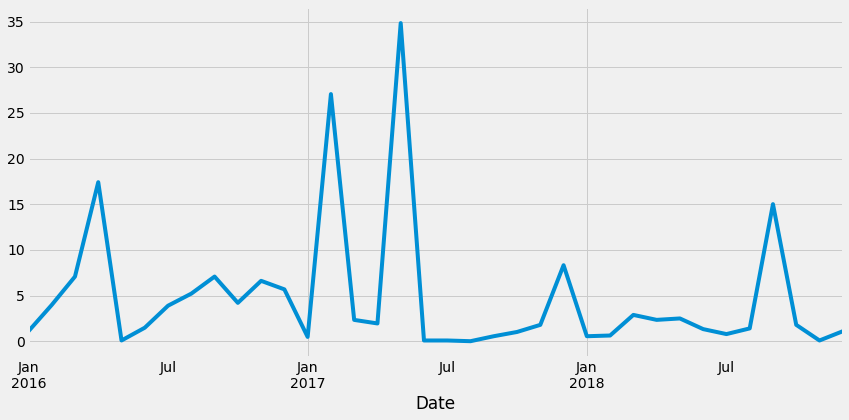

In [19]:
for prod_id in multivariate_product_set:
    
    prod_train_df = group1_products[group1_products.product_id==prod_id].set_index('Date').qty

    prod_train_df.plot(label='Actual', figsize=(13,6))
    ax = forecast_df[f'{prod_id}_forecast'].plot(label=f'Forecast', figsize=(13,6))
    ax.legend(loc='upper left', frameon=False);

    plt.title(f'Product-{prod_id}')
    plt.ylabel('Quantity')
    plt.show()

## Univariate Modelling

### Identify products best suited for univariate modelling:

In [20]:
# productIds with at least 2 years of record availability
group1_product_set = set(group1_products.product_id.unique())

# Identifying products which could not become a part of multivariate modelling
univariate_prod_list = list(group1_product_set - multivariate_product_set)

# putting group1 left out products and group2 products for univariate modelling
univariate_model_prods = list(univariate_prod_list) + list(group2_products.product_id.unique())
univariate_model_prods

['44',
 '11',
 '20',
 '18',
 '30',
 '34',
 '12',
 '23',
 '13',
 '41',
 '33',
 '6',
 '38',
 '29',
 '10',
 '31',
 '19',
 '24',
 '28',
 '8',
 '14',
 '15',
 '21',
 '25',
 '32',
 '42',
 '43',
 '45',
 '47',
 '48',
 '49',
 '51']

### Train Auto-ARIMA Model:

In [21]:
# Auto ARIMA Function
def univariate_modelling(prod_id):
    train = train_set[prod_id].copy()
    test = test_set[prod_id].copy()

    model = auto_arima(train, start_p=5, max_p=8, d=2, start_q=3,
                       trace=True, error_action='ignore', suppress_warnings=True, 
                      n_fits=100,information_criterion='bic')
    model.fit(train)

    forecasted_vals = model.predict(n_periods=12)
    test_df = pd.DataFrame(forecasted_vals, columns=[f'{prod_id}_forecast'], index=test.index)
    test_df = abs(test_df)

    return test_df

In [22]:
uni_forecast_df = pd.DataFrame()
# Iterating over few group1 and all groups 3 product ids
for prod_id in univariate_model_prods:
    print(f'\n\n****** products:{prod_id} ******\n\n')
    prod_forecast = univariate_modelling(prod_id)
    uni_forecast_df = pd.concat([uni_forecast_df, prod_forecast], axis=1)



****** products:44 ******


Performing stepwise search to minimize bic
 ARIMA(5,2,3)(0,0,0)[0]             : BIC=inf, Time=0.60 sec
 ARIMA(0,2,0)(0,0,0)[0]             : BIC=213.606, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : BIC=207.982, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : BIC=inf, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : BIC=203.367, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : BIC=204.512, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0]             : BIC=inf, Time=0.14 sec
 ARIMA(1,2,1)(0,0,0)[0]             : BIC=inf, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : BIC=inf, Time=0.29 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : BIC=206.869, Time=0.06 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 1.329 seconds


****** products:11 ******


Performing stepwise search to minimize bic
 ARIMA(5,2,3)(0,0,0)[0]             : BIC=536.136, Time=0.52 sec
 ARIMA(0,2,0)(0,0,0)[0]             : BIC=558.248, Time=0.01 sec
 ARIMA(1,2,0)(0,0

### Visualize univariate forecasts

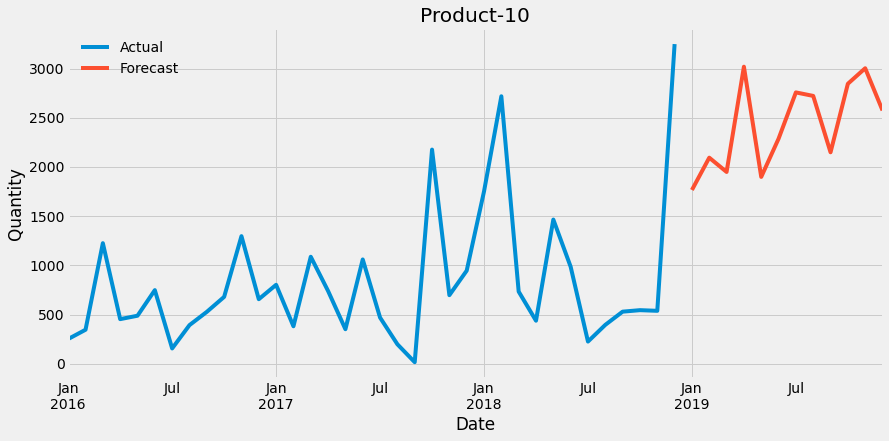

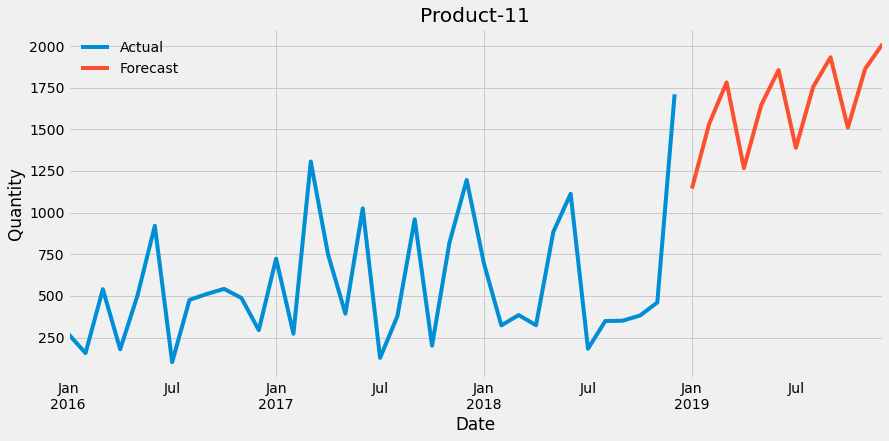

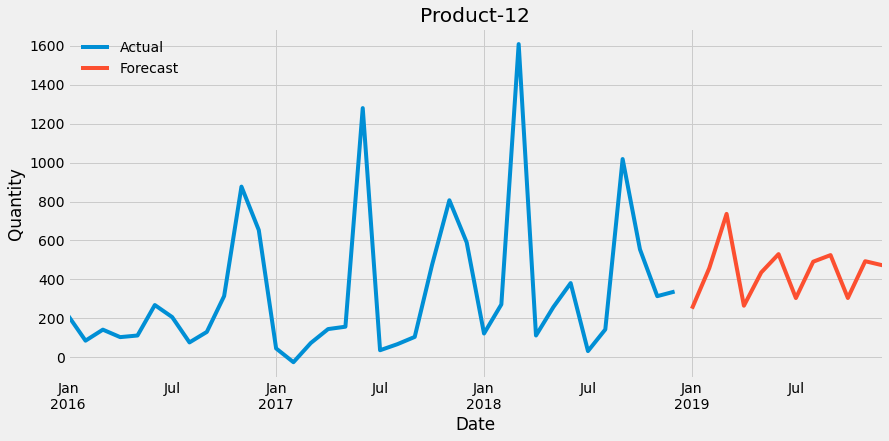

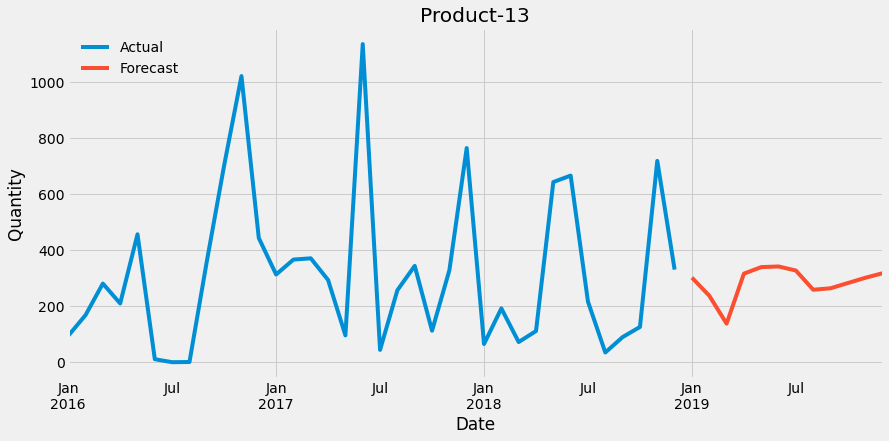

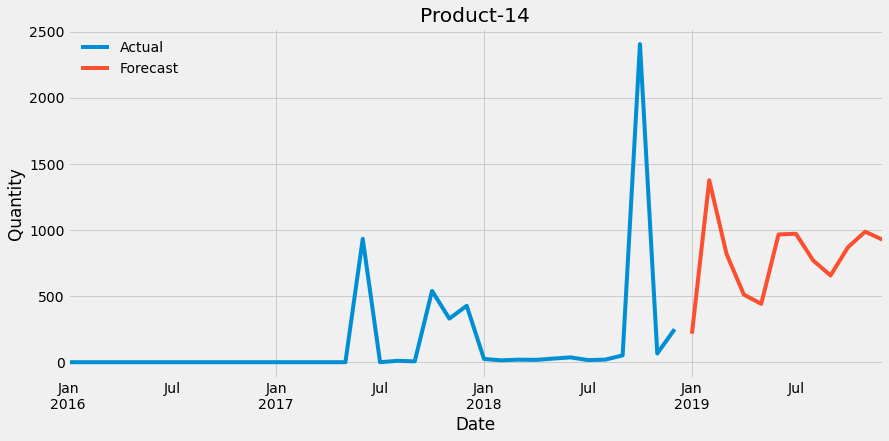

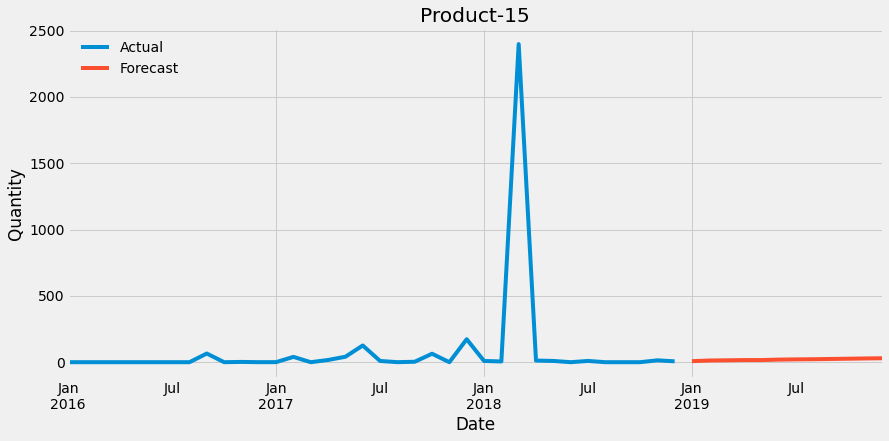

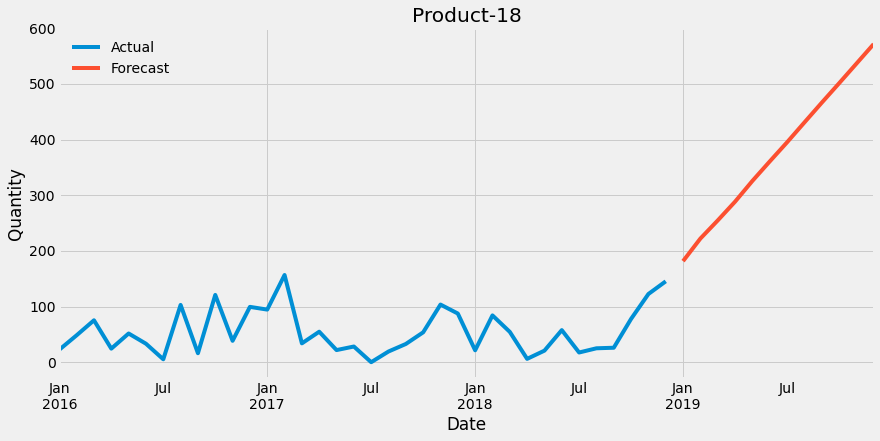

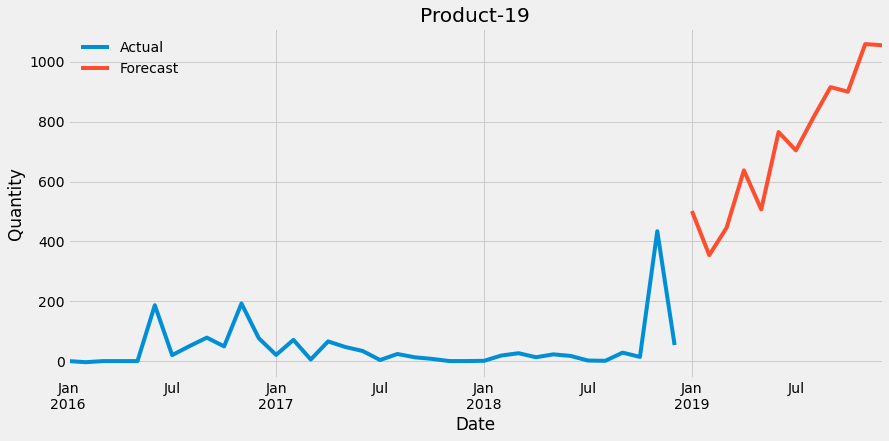

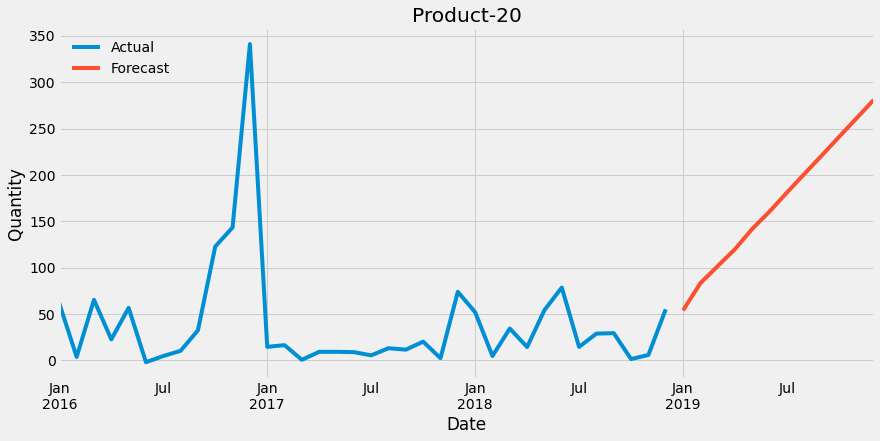

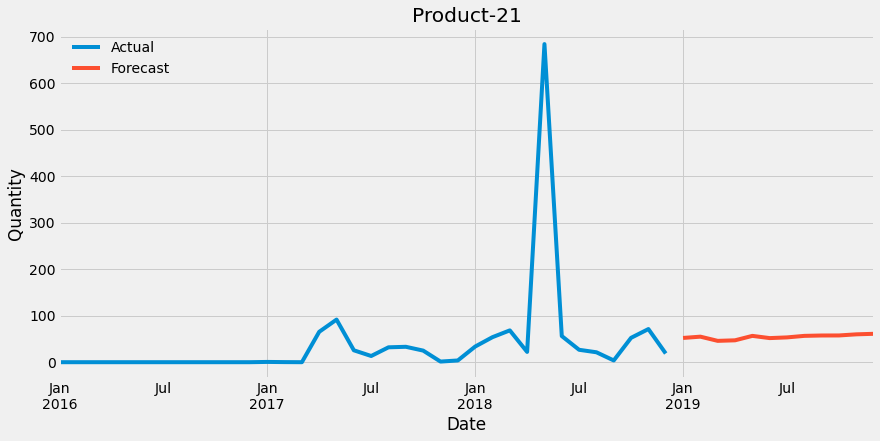

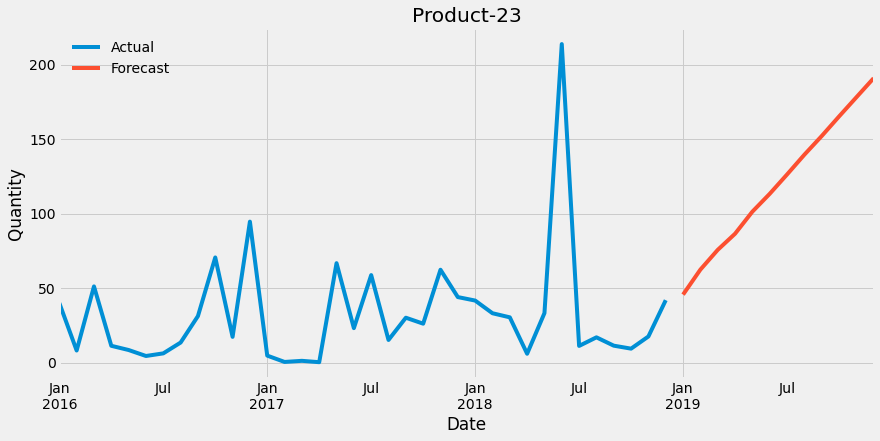

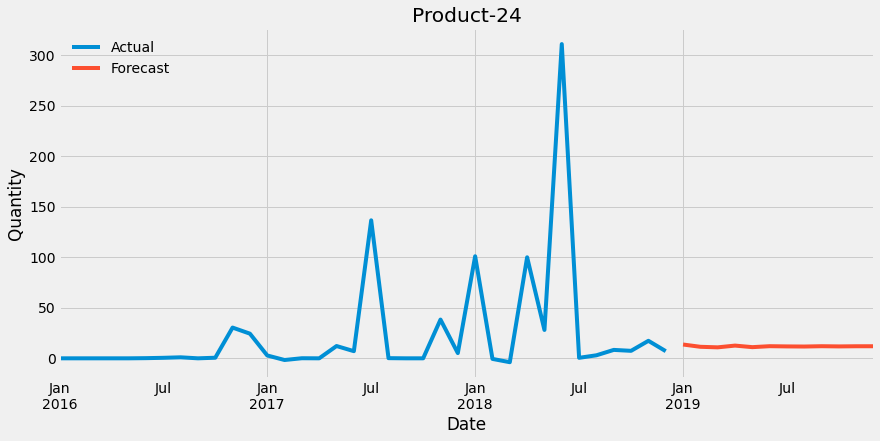

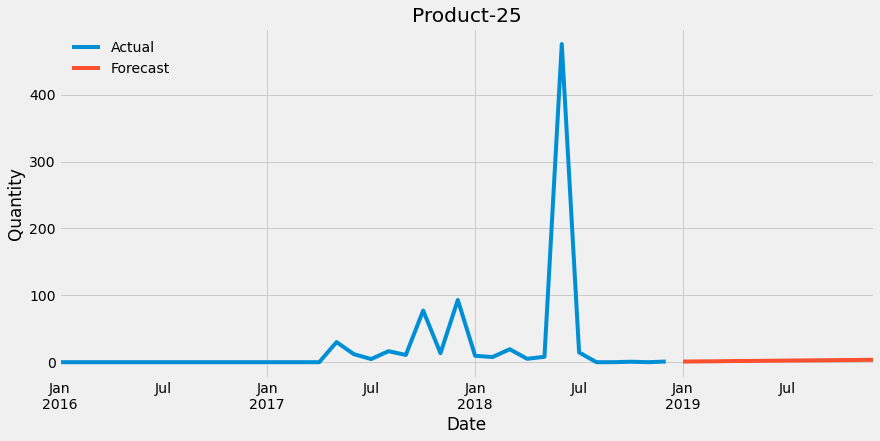

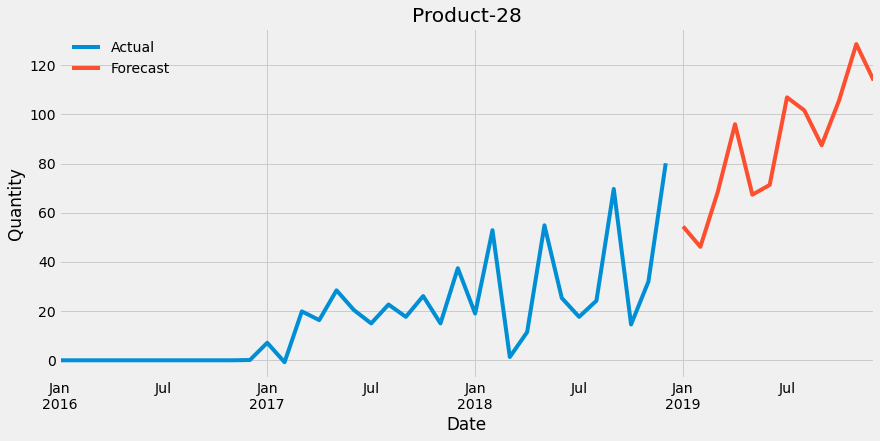

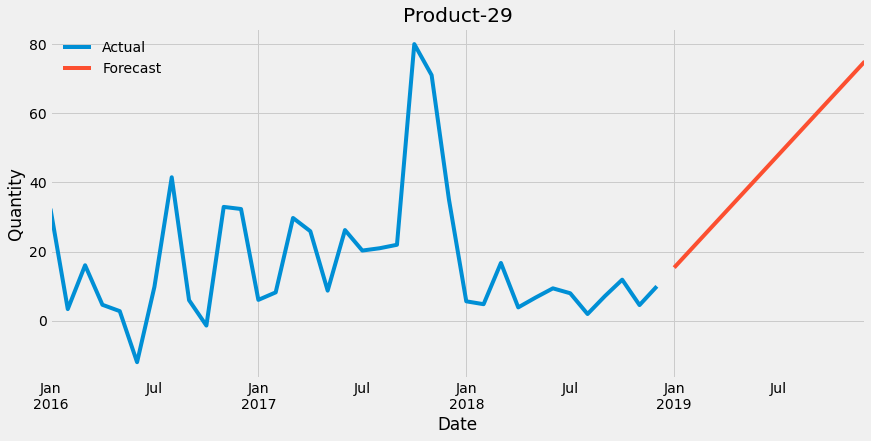

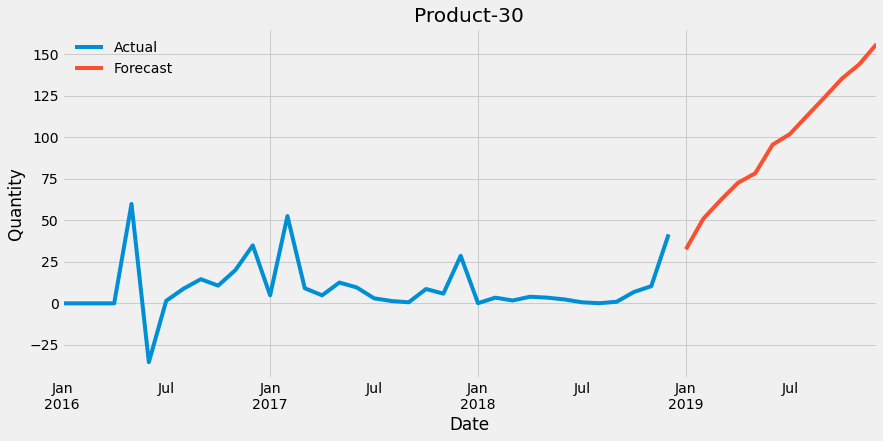

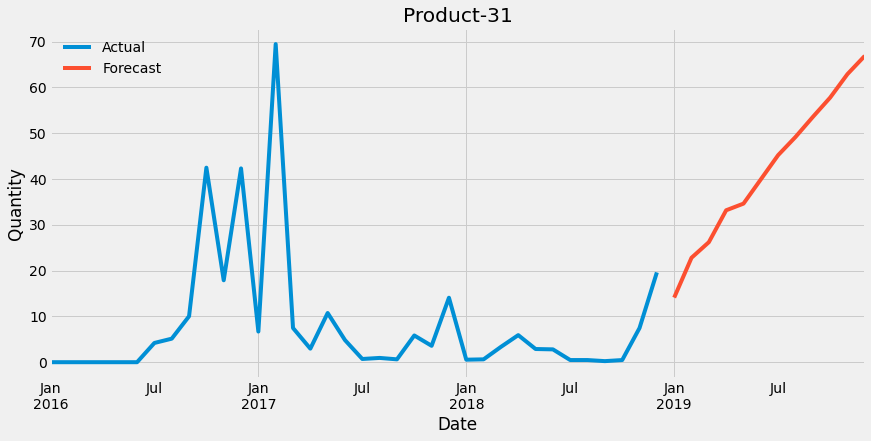

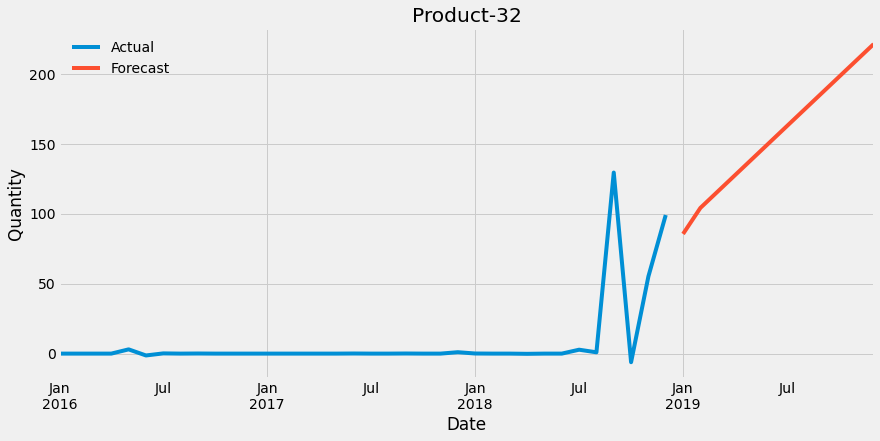

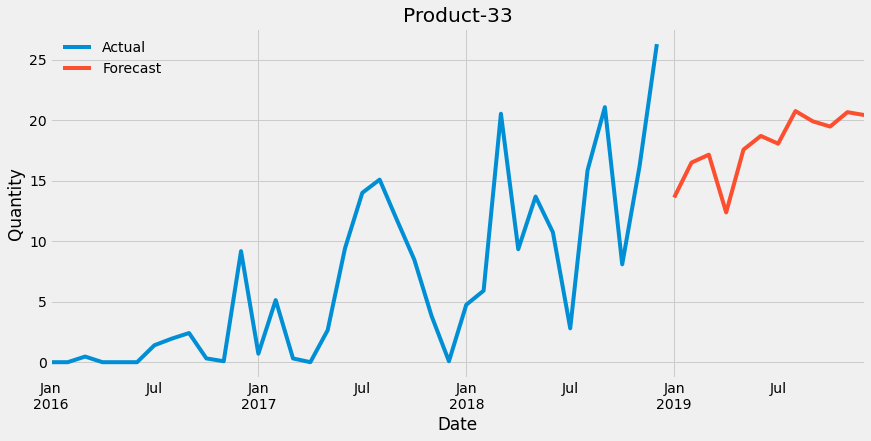

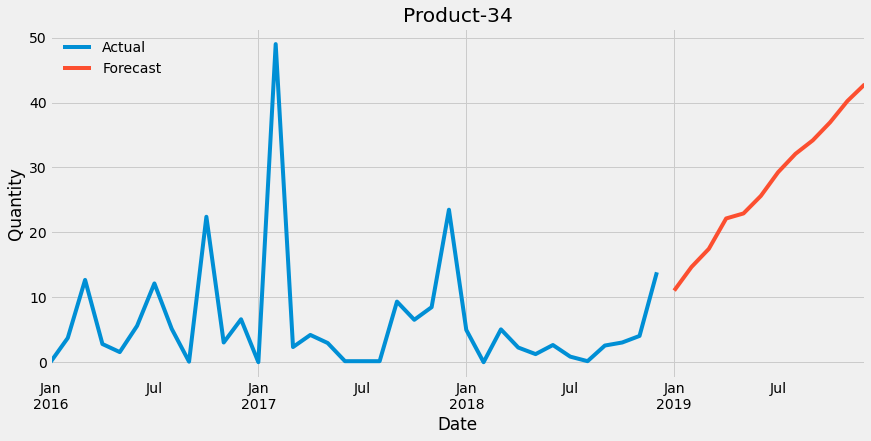

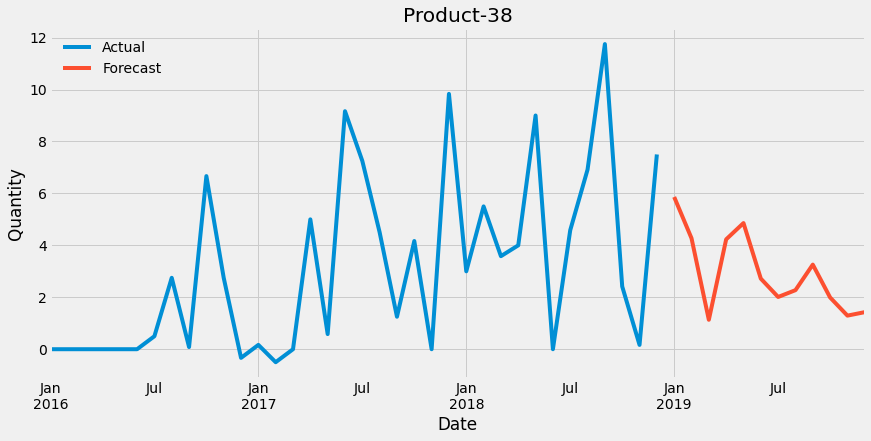

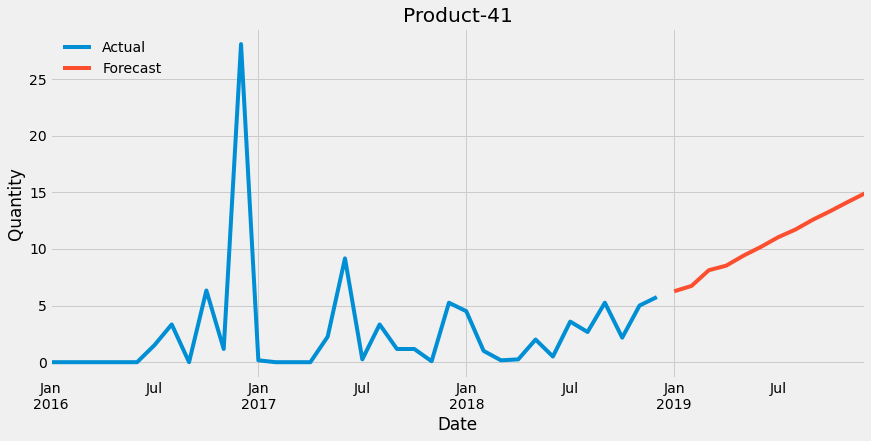

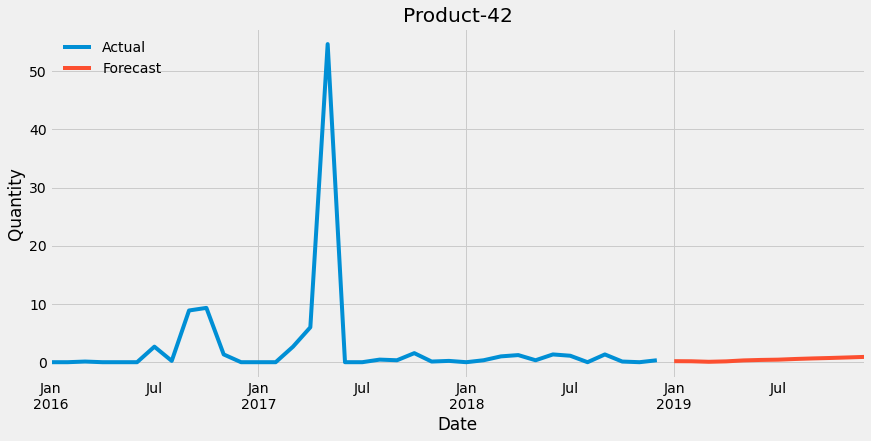

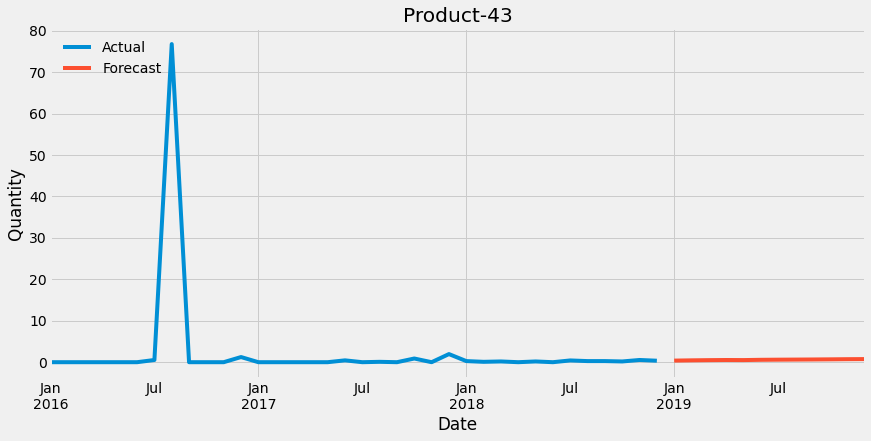

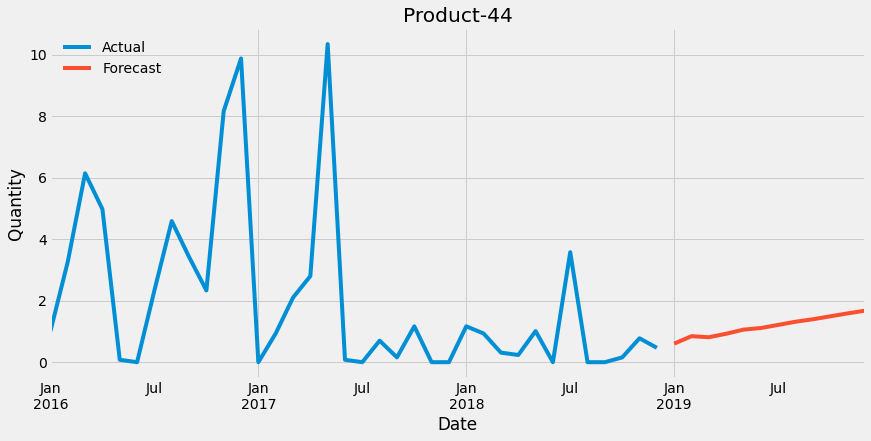

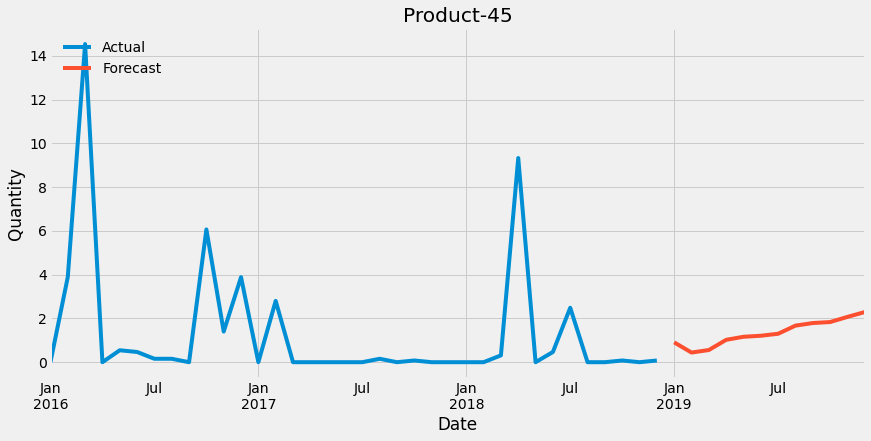

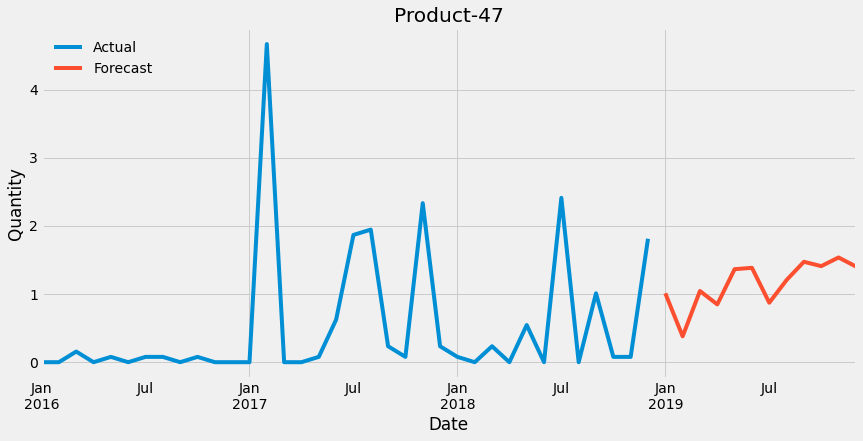

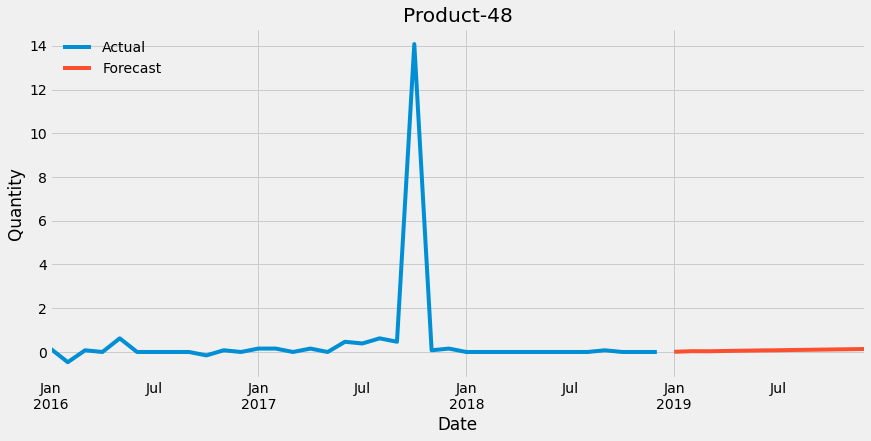

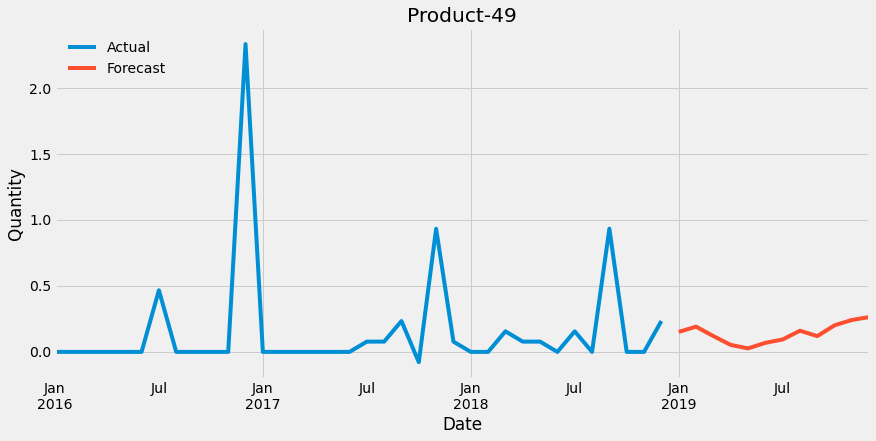

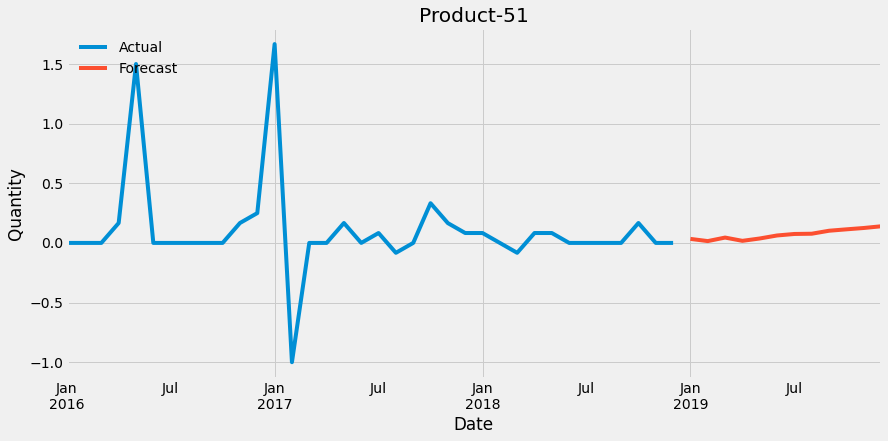

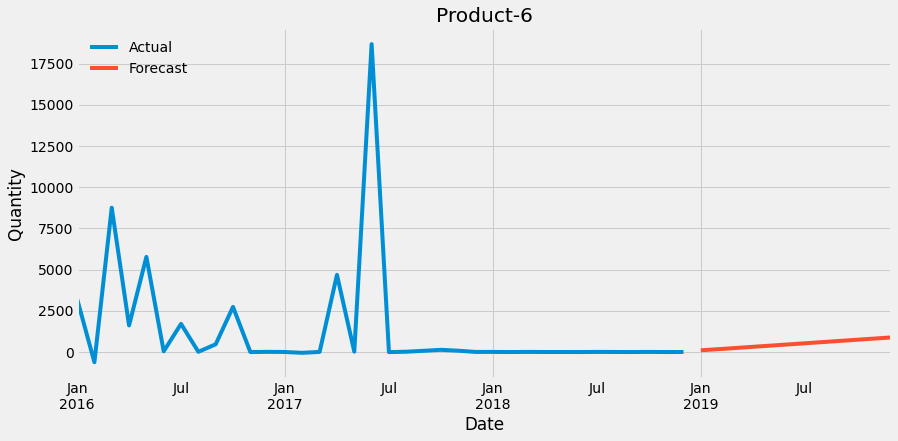

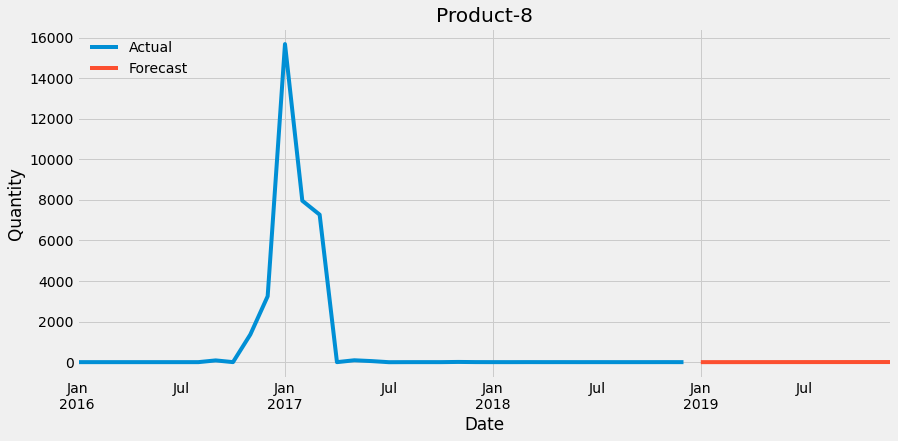

In [23]:

for prod_id in sorted(univariate_model_prods):
    
    prod_train_df = train_set[prod_id]

    prod_train_df.plot(label='Actual', figsize=(13,6))
    ax = uni_forecast_df[f'{prod_id}_forecast'].plot(label=f'Forecast', figsize=(13,6))
    ax.legend(loc='upper left', frameon=False);

    plt.title(f'Product-{prod_id}')
    plt.ylabel('Quantity')
    plt.show()

We are done with Group1 and Group 2 products' forecasting.

### group3_products forecasting

In [24]:
group3_products.product_id.unique()

array(['26', '27', '46', '50', '52', '53', '54', '55', '56', '57', '58',
       '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69',
       '70', '71', '72'], dtype=object)

As explained in use case document, we can find the closet product (from group 1 and group 2), for each groups 3 products. And consider forecast obtained for them.

In [25]:
products_corr_with_group3 = train_set.corr()[group3_products.product_id.unique()]

In [26]:
# DataFrame which will hold complete forecast results
complete_forecast = pd.concat([uni_forecast_df, multivariate_forecast_df], axis=1)

In [27]:
# We are finding the most similar products (from better groups), using med-high correlation.
for p_id in products_corr_with_group3.columns:
    related_prods = products_corr_with_group3[products_corr_with_group3[p_id]>0.5].sort_values(by=p_id)
    related_prods_in_better_grps = set(related_prods.index)-set(group3_products.product_id.unique())    
    complete_forecast[f'{p_id}_forecast'] = complete_forecast[list(related_prods_in_better_grps)[0]+'_forecast']

In [28]:
complete_forecast.columns = complete_forecast.columns.str.replace('_forecast', '')
complete_forecast.columns = complete_forecast.columns.astype(int)
complete_forecast = complete_forecast[range(complete_forecast.columns.min(), complete_forecast.columns.max()+1)]

In [29]:
complete_forecast.to_csv('forecasting_results.csv')

**Scope of Improvement:**

- We can use MICE for data imputation, idea is to perform imputation based on correlated product groups.

- For group3 products, we should scale forecast values to the corresponding product's historical levels.

- For group2 poorly forecasted products, do 'Why analysis' on results to understand the root cause behind the poor forecasts. Once root cause is identified, then after making required adjustments, switch to any other forecasting technique.

- Identify more variables, i.e. market and demand leading indicators. to better perform Multivariate forecasting.

***Go ahead.. fork and explore on your own and let me know your suggestions and doubts in a comment section. Don't forget to upvote if you find it helpful.***